In [3]:
import sys
import numpy as np
import random as rn
import pandas as pd
import torch
from pytorch_pretrained_bert import BertModel
from torch import nn
# from torchnlp.datasets import imdb_dataset      # --> We are using our own uploaded dataset.
from pytorch_pretrained_bert import BertTokenizer
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
rn.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

Using TensorFlow backend.


## Data Preparation

In [5]:
path = '../input/imdb-50k-movie-reviews-test-your-bert/'

train_data = pd.read_csv(path + 'train.csv')
test_data = pd.read_csv(path + 'test.csv')

In [6]:
# experimenting here with a sample of dataset, to avoid memory overflow.
train_data = train_data[:2000]
test_data = test_data[:500]

train_data = train_data.to_dict(orient='records')
test_data = test_data.to_dict(orient='records')
type(train_data)

list

In [7]:
train_texts, train_labels = list(zip(*map(lambda d: (d['text'], d['sentiment']), train_data)))
test_texts, test_labels = list(zip(*map(lambda d: (d['text'], d['sentiment']), test_data)))

len(train_texts), len(train_labels), len(test_texts), len(test_labels)

(2000, 2000, 500, 500)

In [11]:
vocab = set()

for x in train_texts:
    words = x.split()
    a = set(words)
    vocab = vocab.union(a)

In [12]:
for x in test_texts:
    words = x.split()
    a = set(words)
    vocab = vocab.union(a)

In [13]:
word_to_ix = {word: i for i, word in enumerate(vocab)}

In [14]:
!python -m spacy download en_core_web_md

     |████████████████████████████████| 96.4MB 1.4MB/s eta 0:00:017
  Created wheel for en-core-web-md: filename=en_core_web_md-2.2.5-cp36-none-any.whl size=98051304 sha256=7facec837d032c875c813c9366503984ca222553d404db877884aafaee0d8af4
  Stored in directory: /tmp/pip-ephem-wheel-cache-mgzblcfz/wheels/df/94/ad/f5cf59224cea6b5686ac4fd1ad19c8a07bc026e13c36502d81
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [15]:
import en_core_web_md

In [16]:
# Load pre-trained GloVe model
nlp = en_core_web_md.load()
# nlp = spacy.load('en_core_web_md')

In [17]:
# Get word embeddings
word_embeddings = {}
for word in vocab:
    word_embeddings[word] = nlp(word).vector

In [25]:
df = pd.DataFrame.from_dict(word_embeddings)

In [28]:
'''
Save word embeddings for the dataset
'''
df.to_csv('/kaggle/working/embedding.csv', index=False)

In [38]:
df = pd.read_csv('/kaggle/input/word-embeddings/embedding.csv')

In [40]:
word_embeddings = pd.DataFrame.to_dict(df)

In [52]:
embeddings = {}
for word in word_embeddings:
    embeddings[word] = list(word_embeddings[word].values())

In [53]:
train_embeddings = []
for x in train_texts:
    sentence_embed = []
    for word in x.split():
        sentence_embed.append(embeddings[word])
    train_embeddings.append(sentence_embed)

In [58]:
test_embeddings = []
for x in test_texts:
    sentence_embed = []
    for word in x.split():
        sentence_embed.append(embeddings[word])
    test_embeddings.append(sentence_embed)

In [55]:
train_embeddings = np.array(train_embeddings)
train_embeddings = pad_sequences(train_embeddings, maxlen=512, truncating="post", padding="post", dtype=float)

In [59]:
test_embeddings = np.array(test_embeddings)
test_embeddings = pad_sequences(test_embeddings, maxlen=512, truncating="post", padding="post", dtype=float)

In [116]:
test_embeddings[0][0]

array([ 0.08649  ,  0.14503  , -0.4902   ,  0.34224  ,  0.36343  ,
        0.10046  , -0.14904  , -0.28116  , -0.055426 ,  2.2254   ,
       -0.52802  ,  0.17555  ,  0.44629  , -0.25423  , -0.23005  ,
        0.28273  , -0.32839  ,  1.1809   , -0.20102  ,  0.4055   ,
        0.077948 , -0.030626 , -0.25645  ,  0.20382  ,  0.14024  ,
       -0.090318 , -0.18409  , -0.083644 ,  0.025134 ,  0.2383   ,
        0.13716  ,  0.79497  , -0.25215  ,  0.19113  , -0.34871  ,
        0.083896 ,  0.092502 , -0.12733  ,  0.032554 , -0.19932  ,
       -0.1367   ,  0.023516 , -0.28336  ,  0.088996 ,  0.18914  ,
        0.41926  , -0.014874 , -0.062269 ,  0.40566  , -0.14701  ,
       -0.15678  , -0.096457 , -0.31084  , -0.067936 , -0.12819  ,
        0.14578  , -0.34727  , -0.25544  ,  0.22988  , -0.14723  ,
       -0.1626   , -0.29338  ,  0.1139   ,  0.39083  ,  0.3509   ,
       -0.44009  ,  0.084594 , -0.083368 ,  0.0027849,  0.16447  ,
        0.064108 , -0.031757 ,  0.1357   ,  0.3427   ,  0.5076

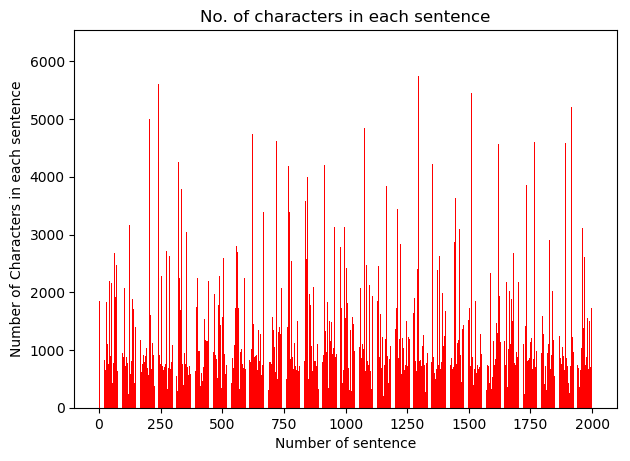

In [11]:
sentences = [len(sent) for sent in train_texts]

plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
plt.bar(range(1,2001), sentences, color = ['red'])
plt.gca().set(title='No. of characters in each sentence', xlabel='Number of sentence', ylabel='Number of Characters in each sentence');

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

100%|██████████| 231508/231508 [00:00<00:00, 1218730.42B/s]


In [10]:
train_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:510] + ['[SEP]'], train_texts))
test_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:510] + ['[SEP]'], test_texts))

len(train_tokens), len(test_tokens)

(2000, 500)

In [11]:
train_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, train_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")
test_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, test_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")

train_tokens_ids.shape, test_tokens_ids.shape

((2000, 512), (500, 512))

In [12]:
train_y = np.array(train_labels) == 'pos'
test_y = np.array(test_labels) == 'pos'
train_y.shape, test_y.shape, np.mean(train_y), np.mean(test_y)

((2000,), (500,), 0.4855, 0.508)

In [13]:
train_masks = [[float(i > 0) for i in ii] for ii in train_tokens_ids]
test_masks = [[float(i > 0) for i in ii] for ii in test_tokens_ids]

# Baseline

In [15]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

In [16]:
baseline_model = make_pipeline(CountVectorizer(ngram_range=(1,3)), LogisticRegression()).fit(train_texts, train_labels)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [17]:
baseline_predicted = baseline_model.predict(test_texts)

In [18]:
print(classification_report(test_labels, baseline_predicted))

              precision    recall  f1-score   support

         neg       0.82      0.84      0.83       246
         pos       0.84      0.83      0.83       254

    accuracy                           0.83       500
   macro avg       0.83      0.83      0.83       500
weighted avg       0.83      0.83      0.83       500



In [14]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

In [50]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, num_layers, num_heads):
        super(TransformerModel, self).__init__()
    
        # Define the positional encoding layer
        self.pos_enc = PositionalEncoding(input_dim)
        self.dropout = nn.Dropout(p=0.3)
        
        # Define the Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=num_heads)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers, norm=nn.LayerNorm(input_dim)).to(device)
        
        temporal_encoder_layer = nn.TransformerEncoderLayer(d_model=input_dim, nhead=num_heads)
        self.temporal_encoder = nn.TransformerEncoder(temporal_encoder_layer, num_layers=num_layers, norm=nn.LayerNorm(input_dim)).to(device)

        self.layer_norm = nn.LayerNorm(input_dim).to(device)
        # Define the fully connected layers
        self.fc1 = nn.Linear(input_dim, hidden_dim1).to(device)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2).to(device)
        self.fc3 = nn.Linear(hidden_dim2, 2).to(device)

    def forward(self, x):
        b = x.shape[0]
        
        # Apply Transformer encoder to input
        x = self.encoder(x)

        # Apply positional encoding to input
        x = self.pos_enc(x)

        # Apply Temporal Transformer encoder to the Encoded Feature of Spatial Transformer
        x = self.temporal_encoder(x)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = x.view(b, -1)
        return x


# Define the positional encoding layer
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout = 0.1, max_len = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)].to(device)
        return self.dropout(x)

In [61]:
X_train = torch.Tensor(train_embeddings).to(device)
y_train = torch.tensor(train_y, dtype=torch.long).to(device)

In [106]:
batch_size = 100

In [81]:
from torch.autograd import Variable

In [74]:
'''
GRU Classification Network
'''

class BinaryGRUClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BinaryGRUClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
        return out

In [114]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

    
class PolicyNetwork(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers = 2):
#         super(PolicyNetwork, self).__init__()
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True).to(device)
#         self.conv1d_1 = nn.Conv1d(hidden_size, 64, kernel_size=3, stride=1, padding=1).to(device)
#         self.conv1d_2 = nn.Conv1d(64, 32, kernel_size=3, stride=1, padding=1).to(device)
#         self.fc = nn.Linear(32, 1).to(device)
# #         self.sigmoid = F.sigmoid().to(device)

#     def forward(self, x):
#         lstm_output, _ = self.lstm(x)
#         lstm_output = lstm_output.permute(0, 2, 1)  # Reshape for conv1d
#         conv1d_output = self.conv1d_1(lstm_output)
#         conv1d_output = self.conv1d_2(conv1d_output)
#         conv1d_output = conv1d_output.permute(0, 2, 1)  # Reshape back
#         fc_output = self.fc(conv1d_output)
#         output = torch.sigmoid(fc_output)
#         return output

    def __init__(self, input_size, hidden_size):
        super(PolicyNetwork, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True).to(device)
        self.fc = nn.Linear(hidden_size, 1).to(device)

    def forward(self, x):
        lstm_output, _ = self.lstm(x)
        fc_output = self.fc(lstm_output)
        output = torch.sigmoid(fc_output)
        return output

'''
LSTM CLASSIFICATION NETWORK
'''
class ClassificationNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ClassificationNetwork, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True).to(device)
        self.fc = nn.Linear(hidden_size, output_size).to(device)

    def forward(self, x):
        b, _, _ = x.shape
        _, (hidden, _) = self.lstm(x)
        output = self.fc(hidden.squeeze(0))
        return output.view(b, -1)

'''
PRE-TRAINED BERT
'''
# class ClassificationNetwork(nn.Module):
#     def __init__(self, dropout=0.1):
#         super(ClassificationNetwork, self).__init__()

#         self.bert = BertModel.from_pretrained('bert-base-uncased')

#         self.dropout = nn.Dropout(dropout)
#         self.linear = nn.Linear(300, 1)
#         self.sigmoid = nn.Sigmoid()
    
#     def forward(self, tokens, masks=None):
#         _, pooled_output = self.bert(tokens, attention_mask=masks, output_all_encoded_layers=False)
#         dropout_output = self.dropout(pooled_output)
#         linear_output = self.linear(dropout_output)
#         proba = self.sigmoid(linear_output)
#         return proba

num_classes = 2  # Number of output classes (binary sentiment)
num_layers = 2  # Number of transformer layers
def calculate_delayed_reward(probabilities, labels):
    positive_reward = torch.log(probabilities) * labels
    negative_reward = torch.log(1 - probabilities) * (1 - labels)
    delayed_reward = positive_reward + negative_reward
    return delayed_reward


# Define the input sizes and hyperparameters
input_size = 300  # Size of embeddings
hidden_size = 256  # Size of hidden units in LSTM
output_size = 2  # Number of classes for sentence sentiment (binary classification)

# Instantiate the policy network and classification network
policy_net = PolicyNetwork(input_size, hidden_size)
# classification_net = ClassificationNetwork(input_size, hidden_size, output_size)
# classification_net = ClassificationNetwork().cuda()
classification_net = BinaryGRUClassifier(input_size, hidden_size, num_layers, num_classes).cuda()

# Initialize the model
# classification_net = TransformerModel(input_dim = 300, hidden_dim1 = 256, hidden_dim2 = 64, num_layers = 4, num_heads = 4)

In [113]:
policy_loss_fn = nn.BCELoss()
policy_optimizer = torch.optim.Adam(policy_net.parameters(), lr=0.5)

classification_loss_fn = nn.CrossEntropyLoss()
classification_optimizer = torch.optim.Adam(classification_net.parameters(), lr=0.5)

In [115]:
num_epochs = 50
for epoch in range(num_epochs):
    
    for i in range(0, X_train.shape[0], batch_size):
        # Get a batch of data
        x_batch = X_train[i:i+batch_size]
        labels = y_train[i:i+batch_size]
    
        # Zero the gradients for both networks
        policy_optimizer.zero_grad()
        classification_optimizer.zero_grad()

        # Forward pass through the policy network
        probabilities = policy_net(x_batch)
#         print(probabilities.size())
        # Forward pass through the classification network
        selected_words = x_batch * probabilities
        prediction = classification_net(selected_words)

        # Compute the classification loss and backpropagate
        classification_loss = classification_loss_fn(prediction, labels)
        classification_loss.backward()
        classification_optimizer.step()
        
        probabilities = probabilities.detach()
        
        # Calculate the delayed reward
        delayed_reward = calculate_delayed_reward(probabilities, labels)
#         print(delayed_reward)
        
        # Compute the policy loss and backpropagate
        policy_loss = torch.sum(-delayed_reward)
        policy_loss = Variable(policy_loss, requires_grad = True)
        policy_loss.backward()
        policy_optimizer.step()


    # Print the loss for monitoring
    print(f"Epoch {epoch + 1}: Policy Loss: {policy_loss.item()}, "
          f"Classification Loss: {classification_loss.item()}")
#     print(f"Epoch {epoch + 1}: Classification Loss: {classification_loss.item()}")

# After training, you can use the networks for inference.

Epoch 1: Policy Loss: 3540325.0, Classification Loss: 0.692048192024231
Epoch 2: Policy Loss: 3540325.0, Classification Loss: 0.692048192024231
Epoch 3: Policy Loss: 3540325.0, Classification Loss: 0.692048192024231
Epoch 4: Policy Loss: 3540325.0, Classification Loss: 0.692048192024231
Epoch 5: Policy Loss: 3540325.0, Classification Loss: 0.692048192024231
Epoch 6: Policy Loss: 3540325.0, Classification Loss: 0.692048192024231
Epoch 7: Policy Loss: 3540325.0, Classification Loss: 0.692048192024231
Epoch 8: Policy Loss: 3540325.0, Classification Loss: 0.692048192024231
Epoch 9: Policy Loss: 3540325.0, Classification Loss: 0.692048192024231
Epoch 10: Policy Loss: 3540325.0, Classification Loss: 0.692048192024231
Epoch 11: Policy Loss: 3540325.0, Classification Loss: 0.692048192024231
Epoch 12: Policy Loss: 3540325.0, Classification Loss: 0.692048192024231
Epoch 13: Policy Loss: 3540325.0, Classification Loss: 0.692048192024231
Epoch 14: Policy Loss: 3540325.0, Classification Loss: 0.692

In [69]:
X_test = torch.Tensor(test_embeddings).to(device)
y_test = torch.tensor(test_y, dtype=torch.long).cpu()

In [70]:
from sklearn.metrics import accuracy_score

In [104]:
with torch.no_grad():
    probabilities = policy_net(X_test)
    # Forward pass through the classification network
    selected_words = X_test * probabilities
    prediction = classification_net(selected_words).cpu()
    prediction = np.argmax(prediction, axis = 1)

    # Compute the classification loss and backpropagate
    acc = accuracy_score(prediction, y_test)
print(acc)

0.506
